In [1]:
import sys
sys.path.append("../Modules/")
sys.path.append("../")
import os

import pandas as pd
import numpy as np

from configobj import ConfigObj
from configobj import flatten_errors
from validate import Validator
    
import logging

#fmt = 'logging.Formatter(''%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)


In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [7]:
allTrialData = pd.read_pickle('../allTrialData.pickle')


In [8]:
from processDataE1 import removeOutliers
allTrialData = removeOutliers(allTrialData,'meanGazeToBallDistDuringWindow',stdRange=2.5)


INFO_processDataE1-removeOutliers(): - Removed 6 outliers from meanGazeToBallDistDuringWindow


In [9]:
fixDf_ipd_passLoc_bl_sub = allTrialData.groupby(['ipdRatio',
                                                  'passingLocX',
                                                  'blockNumber',
                                                  'fileName'])


ipdRatioList = list(np.sort(allTrialData.groupby('ipdRatio').groups.keys()))
passingLocXList = list(np.sort(allTrialData.groupby('passingLocX').groups.keys()))
blockList = list(allTrialData.groupby('blockNumber').groups.keys())
fileNames = list(allTrialData.groupby('fileName').groups.keys())

numIpd = len(ipdRatioList)
numPassingLoc = len(passingLocXList)
numBlock = len(blockList)
numSub = len(fileNames)

meanGtoBDuringWindow_ipd_pass_bl_sub = np.zeros([numIpd,numPassingLoc,numBlock, numSub])
stdGtoBDuringWindow_ipd_pass_bl_sub = np.zeros([numIpd,numPassingLoc,numBlock, numSub])

fileNames_sub = []
for (ipd,pLoc,bl,sub), data in fixDf_ipd_passLoc_bl_sub:

    # Iterate through groups, while keeping track of which group we're in.
    # The tuple (,pLoc,bl,sub) contains the group indices
    # The variable data is a dataframe containing rows in that group 
    
    # Convert group indices to numeric indices into their value lists
    # ...what is the index of a  of 0.5 in the ipdRatioList?
    
    ipdIdx  = [i for i, s in enumerate(ipdRatioList) if ipd == s]
    plocIdx  = [i for i, s in enumerate(passingLocXList) if pLoc == s]  
    blIdx  = [i for i, s in enumerate(blockList) if bl == s]
    subIdx  = [i for i, s in enumerate(fileNames) if sub == s]


    meanGtoBDuringWindow_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data[('meanGazeToBallDistDuringWindow','')].mean()
    stdGtoBDuringWindow_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data[('meanGazeToBallDistDuringWindow','')].std()


In [10]:
meanGtoBDuringWindow_ipd_pass_bl_sub

array([[[[0.        , 0.        , 0.        , 0.        ],
         [0.87175031, 1.11561027, 0.67851927, 0.8961189 ]],

        [[0.        , 0.        , 0.        , 0.        ],
         [0.91505765, 1.11230165, 0.87113544, 0.98385074]],

        [[0.        , 0.        , 0.        , 0.        ],
         [1.05721867, 1.44448862, 1.37595715, 1.19977748]]],


       [[[0.        , 0.        , 0.        , 0.        ],
         [0.8987009 , 0.89823045, 1.09544155, 0.95541557]],

        [[0.        , 0.        , 0.        , 0.        ],
         [1.13253376, 1.14562459, 1.28301276, 1.17254772]],

        [[0.        , 0.        , 0.        , 0.        ],
         [1.04771441, 1.49493881, 1.31650446, 1.19689682]]],


       [[[1.09805186, 1.03957193, 1.0571851 , 1.05922395],
         [1.11049888, 1.21886221, 1.41176858, 1.25088974]],

        [[1.03928208, 1.1627227 , 1.24274521, 1.302557  ],
         [1.48622656, 1.40039162, 1.34929681, 1.13931828]],

        [[1.27972832, 1.43155123, 1.

#  Mean G2B distance during window all subs

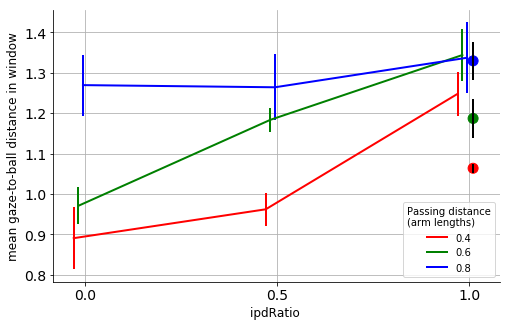

In [11]:
plotSubData = True

##############
nSubs = np.shape(meanGtoBDuringWindow_ipd_pass_bl_sub)[3]
meanGtoBDuringWindow_ipd_pass_bl  = np.nanmean(meanGtoBDuringWindow_ipd_pass_bl_sub,axis=3)
stdGtoBDuringWindow_ipd_pass_bl = np.nanstd(meanGtoBDuringWindow_ipd_pass_bl_sub,axis=3) / np.sqrt(nSubs)

#pctCaught_ipd_passLoc_bl_sub

p, ax = plt.subplots(1, 1) #sharey=True)

cList = ['r','g','b']
offsets = np.linspace(-.03,.03,6)

# Block 1
for pIdx, pVal in enumerate(passingLocXList):

    x = ipdRatioList + offsets[pIdx]
    y = meanGtoBDuringWindow_ipd_pass_bl[:,pIdx,1]
    yerr = stdGtoBDuringWindow_ipd_pass_bl[:,pIdx,1]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")
    
#######

bIdx = 0
cList = ['r','g','b']

ax.scatter(x = [1+.01] * len(meanGtoBDuringWindow_ipd_pass_bl[2,:,bIdx]) , 
           y = meanGtoBDuringWindow_ipd_pass_bl[2,:,bIdx],
          s=100,c=cList)

ax.errorbar(x = [1+.01] * len(meanGtoBDuringWindow_ipd_pass_bl[2,:,bIdx]), 
            y = meanGtoBDuringWindow_ipd_pass_bl[2,:,bIdx],
            yerr = stdGtoBDuringWindow_ipd_pass_bl[2,:,bIdx] ,
            elinewidth=2,
            ecolor = 'k',fmt="none")

plt.gcf().set_size_inches(8,5)
ax.set_ylabel('mean gaze-to-ball distance in window', fontsize=12)
ax.set_xlabel('ipdRatio ', fontsize=12)

plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(ipdRatioList)
ax.tick_params(axis='both', which='major', labelsize=14)

p.set_facecolor('w')

# outDir = '../subFigs/'
# if not os.path.exists(outDir):
#     os.makedirs(outDir)
# fName = outDir + 'meanCatchingRates.png'
# plt.savefig(fName, facecolor=p.get_facecolor(), transparent=True)
